<a href="https://colab.research.google.com/github/ftk1000/py_lessons/blob/main/regr_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# regr_fuel_efficiency.ipynb
# https://github.com/ftk1000/py_lessons/blob/main/regr_fuel_efficiency.ipynb

# 2022.02.25

# YouTube channel for more! → http://bit.ly/TensorFlow1


# Get the Colab & follow along here → https://www.tensorflow.org/tutorials/...
# UCI dataset repository → http://bit.ly/2k2xH8i


# Watch more Coding TensorFlow → https://bit.ly/Coding-TensorFlow


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

2.8.0


In [4]:
# The Auto MPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# clean the data = find entries with unknown values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# remove the corresponding rows
dataset = dataset.dropna()

# The "Origin" column is categorical, not numeric. So the next step 
# is to one-hot encode the values in the column with pd.get_dummies.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
# Split the data into training and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

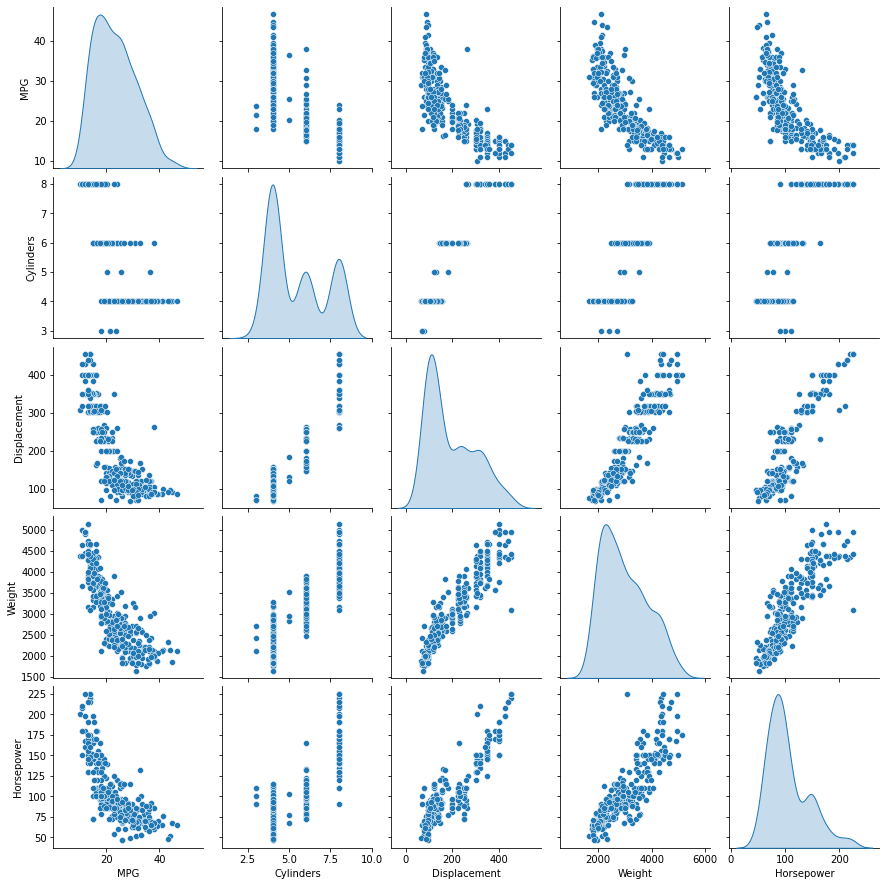

In [9]:
# Inspect the (train) data:
# Review the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight', 'Horsepower' ]], diag_kind='kde')



In [10]:
# Let's also check the overall statistics. 
# Note how each feature covers a very different range:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [11]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [12]:
print(train_dataset.shape)
# Normalization
train_dataset.describe().transpose()[['mean', 'std']]


(314, 10)


,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [13]:
'''
The Normalization Layer

It is good practice to normalize features that use different scales and ranges.
One reason this is important is because the features are multiplied by the model 
weights. So, the scale of the outputs and the scale of the gradients are 
affected by the scale of the inputs.
Although a model might converge without feature normalization, normalization 
makes training much more stable.
'''
normalizer = tf.keras.layers.Normalization(axis=-1)

# Then, fit the state of the preprocessing layer to the data 
#  by calling Normalization.adapt:
normalizer.adapt(np.array(train_features))

# Calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())



[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]
[[     2.88   10850.413   1446.699 709896.9        7.755     13.467
       0.147      0.158      0.235]]


In [14]:
# a quick example of tf.keras.layers.Normalization(axis=-1)
#    layer = tf.keras.layers.Normalization(axis=None)
norm2 = tf.keras.layers.Normalization(axis=None, mean=None, variance=None)
adapt_data = np.array([1., 2., 3., 4., 5.], dtype='float32')
norm2.adapt(adapt_data)
mean = norm2.mean.numpy()[0]
print(f'mean = {mean}')
variance = norm2.variance.numpy()[0]
print('variance = ', variance )

input_data = np.array([1., 2., 3.], dtype='float32')
print(norm2(input_data))

'''
- The variance measures the average degree to which points differ from the mean.
- Standard deviation = square root of the variance
     x=[1, 2, 3, 4, 5], mean = 3
  variance = {(3-1)^2 + (3-2)^2 + ... + (3-5)^2} / 5 = {4+1+0+1+4}/5 = 10/5 = 2
  std.dev  = \sqrt(variance) = \sqrt(2) = 1.41 
'''

(input_data - mean)/np.sqrt(variance)

mean = 3.0
variance =  2.0
tf.Tensor([-1.414 -0.707  0.   ], shape=(3,), dtype=float32)


array([-1.414, -0.707,  0.   ], dtype=float32)

In [15]:
# show train_features and train_labels
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [16]:
print('train_labels  (MPG):')
train_labels

train_labels  (MPG):


146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

# Linear Regression with 1 predictor

In [17]:
# Use only one feature
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

# build sequential model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [18]:
%%time
'''
Once the model is built, configure the training procedure using the 
Keras Model.compile method. The most important arguments to compile are 
the loss and the optimizer, since these define what 
will be optimized (mean_absolute_error) and 
how (using the tf.keras.optimizers.Adam).
'''
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.66 s, sys: 164 ms, total: 5.83 s
Wall time: 8.84 s


        loss  val_loss  epoch
95  3.802776  4.191500     95
96  3.808028  4.220333     96
97  3.804765  4.185490     97
98  3.802742  4.186182     98
99  3.801842  4.196756     99


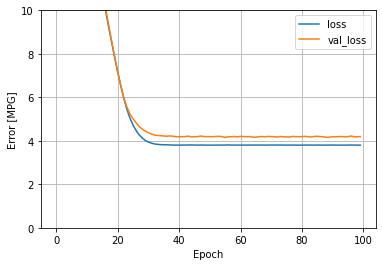

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)  

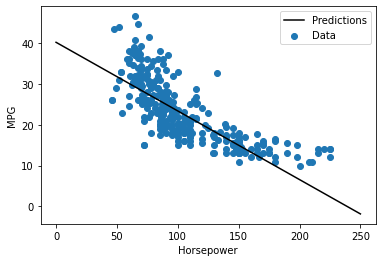

In [20]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

# DNN  regression with 10 features

$$ y = mx + b $$

In [21]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model



normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


CPU times: user 4.77 s, sys: 224 ms, total: 5 s
Wall time: 5.21 s


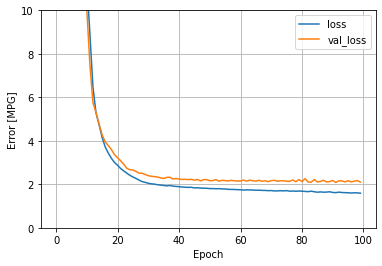

In [22]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

# Performance

In [23]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'], test_labels, verbose=0)

test_results['dnn_model'] = dnn_model.evaluate(
    test_features, test_labels, verbose=0)

print(test_results)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

{'horsepower_model': 3.6469757556915283, 'dnn_model': 1.7644683122634888}


,Mean absolute error [MPG]
horsepower_model,3.646976
dnn_model,1.764468


In [24]:
test_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1


In [25]:
dnn_model_predictions = dnn_model.predict(test_features).flatten()
hpw_model_predictions = horsepower_model.predict(test_features['Horsepower']).flatten()


In [26]:
# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, hpw_model_predictions, c='red',  alpha=0.4)
# plt.scatter(test_labels, dnn_model_predictions, c='blue', alpha=0.4)
# plt.xlabel('True Values [MPG]')
# plt.ylabel('Predictions [MPG]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [27]:
# error = hpw_model_predictions - test_labels
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error [MPG]')
# _ = plt.ylabel('Count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd59cf3f790>,
      dtype=object)

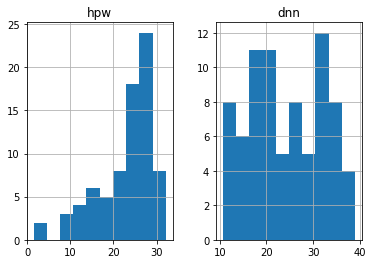

In [28]:
pd.DataFrame({'hpw':hpw_model_predictions, 'dnn':dnn_model_predictions}).hist()

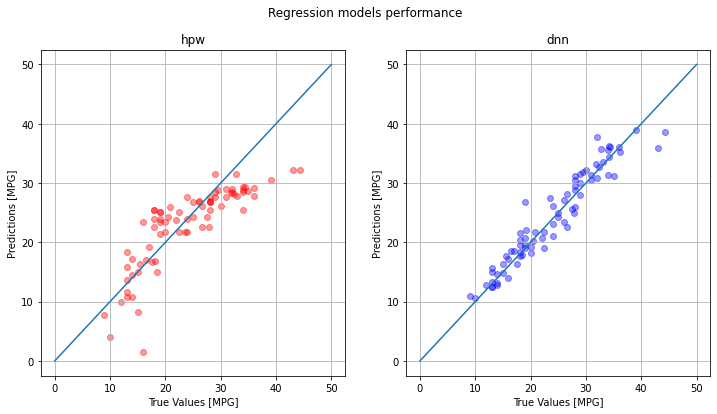

In [29]:
import numpy as np
import matplotlib.pyplot as plt

lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))

ax0.set_title('hpw')
ax0.scatter(test_labels, hpw_model_predictions, c='red',  alpha=0.4)
ax0.set_xlabel('True Values [MPG]')
ax0.set_ylabel('Predictions [MPG]')
ax0.grid(True)
ax0.plot(lims,lims)

ax1.set_title('dnn')
ax1.scatter(test_labels, dnn_model_predictions, c='blue', alpha=0.4)
ax1.set_xlabel('True Values [MPG]')
ax1.set_ylabel('Predictions [MPG]')
ax1.grid(True)
ax1.plot(lims,lims)

fig.suptitle('Regression models performance')
plt.show()